In [1]:
pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 85kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 3.2MB 14.3MB/s 
     |████████████████████████████████| 491kB 39.3MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [4]:
# Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

In [5]:
# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 2

In [6]:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [7]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [8]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

In [9]:
# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

In [10]:
# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [11]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

In [12]:
loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Step 1, Loss: 646.789673
Step 1000, Loss: 185.859222
Step 2000, Loss: 175.662689
Step 3000, Loss: 163.750778
Step 4000, Loss: 153.226379
Step 5000, Loss: 153.470749
Step 6000, Loss: 161.473083
Step 7000, Loss: 160.008286
Step 8000, Loss: 168.908875
Step 9000, Loss: 164.706024
Step 10000, Loss: 151.886993
Step 11000, Loss: 152.491608
Step 12000, Loss: 153.963058
Step 13000, Loss: 156.769196
Step 14000, Loss: 155.421204
Step 15000, Loss: 149.591141
Step 16000, Loss: 146.731064
Step 17000, Loss: 151.895737
Step 18000, Loss: 152.439240
Step 19000, Loss: 151.620544
Step 20000, Loss: 142.878174
Step 21000, Loss: 161.124161
Step 22000, Loss: 146.048218
Step 23000, Loss: 161.450012
Step 24000, Loss: 161.955780
Step 25000, Loss: 139.364029
Step 26000, Loss: 162.859985
Step 27000, Loss: 161.569244
Step 28000, Loss: 154.949875
Step 29000, Loss: 158.085922
Step 30000, Loss: 159.814087


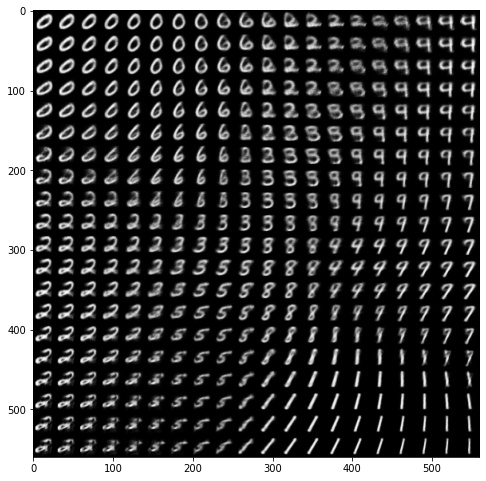

In [14]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Train
        feed_dict = {input_image: batch_x}
        _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
        if i % 1000 == 0 or i == 1:
            print('Step %i, Loss: %f' % (i, l))

    # Testing
    # Generator takes noise as input
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    # Rebuild the decoder to create image from noise
    decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoder = tf.nn.sigmoid(decoder)

    # Building a manifold of generated digits
    n = 20
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]] * batch_size)
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
            x_mean[0].reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()